In [10]:
%matplotlib inline
import numpy as np
from skimage import feature
from skimage import morphology
from skimage import measure
from skimage.transform import resize

import matplotlib.pyplot as plt

def make_mask(img, threshold=.5):
    row_size= img.shape[0]
    col_size = img.shape[1]

    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    eroded = morphology.erosion(thresh_img,np.ones([9,9]))
    
    mask = np.where(eroded,0.0,1.0)
    mask = morphology.dilation(mask,np.ones([10,10]))
    
    copy = np.copy(img)
    copy[copy < 0] = 0
    
    return mask

In [2]:
x = np.load('data/151631_394.npy')

In [24]:
x_mask = np.array([make_mask(slc) for slc in x])

In [25]:
y = np.array([feature.canny(slc, sigma=2) for slc in x])

In [26]:
z = x_mask * y

In [31]:
to_check = 42

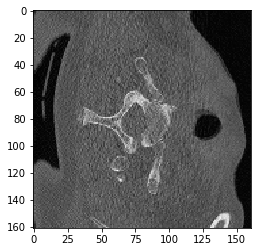

In [32]:
plt.imshow(x[42], cmap='gray')

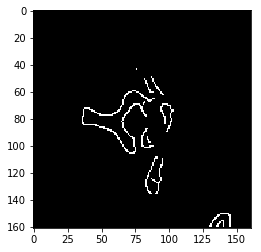

In [33]:
plt.imshow(z[42], cmap='gray')

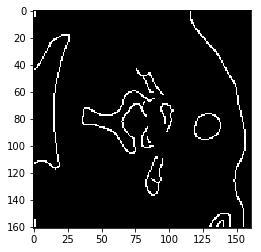

In [34]:
plt.imshow(y[42], cmap='gray')

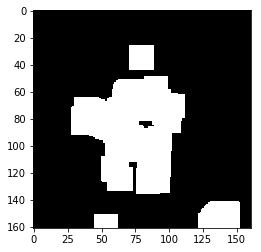

In [35]:
plt.imshow(x_mask[42], cmap='gray')

In [38]:
np.sum(z)

176476.0